In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab/Capstone/datasets/

/content/drive/MyDrive/Colab/Capstone/datasets


In [46]:
# load data

data_heatmap = pd.read_csv('A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('A_data_domain_perf_metrics_300x250_3p.csv')

# Isolation Forest

## Library



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

## Data Manipulation

In [66]:
# expand the data
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1  # Set clicks to 1 for each row

# number of bins for the grid
NR_OF_X_BINS = 61  # 60 bins + 1 for edge
NR_OF_Y_BINS = 51  # 50 bins + 1 for edge

# bin edges
max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()
width_bins = np.linspace(0, max_width + 1, NR_OF_X_BINS)
height_bins = np.linspace(0, max_height + 1, NR_OF_Y_BINS)

# clicks to bins
data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], bins=width_bins, labels=range(NR_OF_X_BINS-1), include_lowest=True)
data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], bins=height_bins, labels=range(NR_OF_Y_BINS-1), include_lowest=True)

aggregated_clicks = data_heatmap_expanded.groupby(['grid_id', 'domain', 'click_x_bin', 'click_y_bin'])['clicks'].sum().reset_index()

# multi-index by setting grid_id, domain, click_x_bin, and click_y_bin as indices
aggregated_clicks.set_index(['grid_id', 'domain', 'click_x_bin', 'click_y_bin'], inplace=True)

# unstack filling missing values with 0
data_for_modeling = aggregated_clicks.unstack(level=['click_x_bin', 'click_y_bin'], fill_value=0)

# flatten the column multi-index
data_for_modeling.columns = ['bin_{}_{}'.format(x_bin, y_bin) for x_bin, y_bin in data_for_modeling.columns.droplevel(0)]


In [77]:
# clearly broken domain IDs from Martin
broken_domains = [
    'ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
    'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
    'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
    'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
    'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
    'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
    'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
    'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
    'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
    'ID_962', 'ID_986'
]


## Apply Method


### For My Data

In [67]:
anomaly_results = {}

unique_grid_ids = data_for_modeling.index.get_level_values('grid_id').unique()
for grid_id in unique_grid_ids:

    data_current_grid = data_for_modeling.loc[grid_id].dropna(axis=1, how='all')  # Drop all-NaN columns if any exist

    # model
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(data_current_grid)

    # predict
    anomalies = iso_forest.predict(data_current_grid)

    anomaly_results[grid_id] = pd.DataFrame({
        'domain': data_current_grid.index,
        'anomaly': anomalies
    }, index=data_current_grid.index)


## Result Exploration

In [68]:
anomaly_percentages = {}

for grid_id, results in anomaly_results.items():
    total_domains = len(results)
    anomalies_count = (results['anomaly'] == -1).sum()
    anomaly_percentage = (anomalies_count / total_domains) * 100
    anomaly_percentages[grid_id] = anomaly_percentage

anomaly_percentages


{333346: 5.784399649430324, 333519: 5.872042068361086}

In [69]:
# across all grid_ids
total_anomalies = sum((result['anomaly'] == -1).sum() for result in anomaly_results.values())
total_domains_aggregate = sum(len(result) for result in anomaly_results.values())

overall_anomaly_percentage = (total_anomalies / total_domains_aggregate) * 100
overall_anomaly_percentage


5.828220858895705

In [75]:
anomaly_counts = {}

for grid_id, results in anomaly_results.items():
    anomaly_count = (results['anomaly'] == -1).sum()
    non_anomaly_count = (results['anomaly'] == 1).sum()

    anomaly_counts[grid_id] = {'Anomalies': anomaly_count, 'Non-Anomalies': non_anomaly_count}

anomaly_counts


{333346: {'Anomalies': 66, 'Non-Anomalies': 1075},
 333519: {'Anomalies': 67, 'Non-Anomalies': 1074}}

In [119]:
def plot_heatmaps_from_clicks(grid_id, domains, data_expanded, NR_OF_X_BINS, NR_OF_Y_BINS, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, domain in zip(axes.flatten(), domains):
        domain_data = data_expanded[(data_expanded['domain'] == domain) & (data_expanded['grid_id'] == grid_id)]

        heatmap_data, _, _ = np.histogram2d(
            x=domain_data['click_x'],
            y=domain_data['click_y'],
            bins=[NR_OF_X_BINS - 1, NR_OF_Y_BINS - 1],
            range=[[0, max_width], [0, max_height]]
        )

        sns.heatmap(heatmap_data.T, ax=ax, cmap="viridis", cbar=True)  # Transpose to align the axes
        ax.set_title(f'Grid ID: {grid_id}, Domain: {domain}')
        ax.set_xlabel('X Bin')
        ax.set_ylabel('Y Bin')

    plt.tight_layout()
    plt.show()


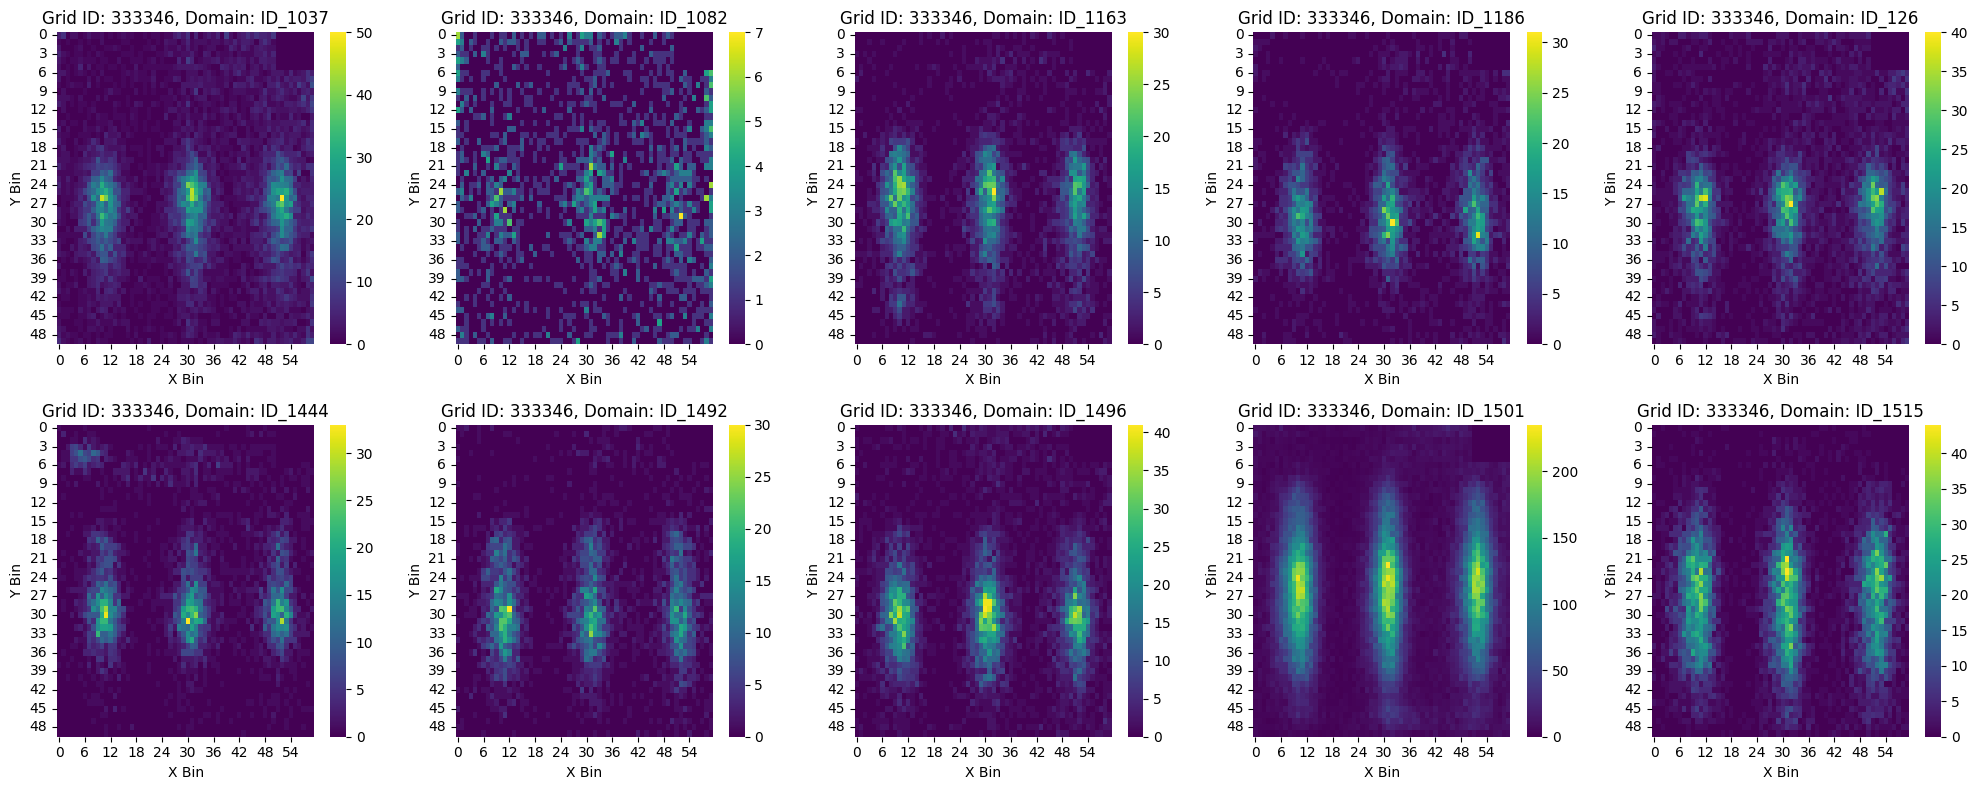

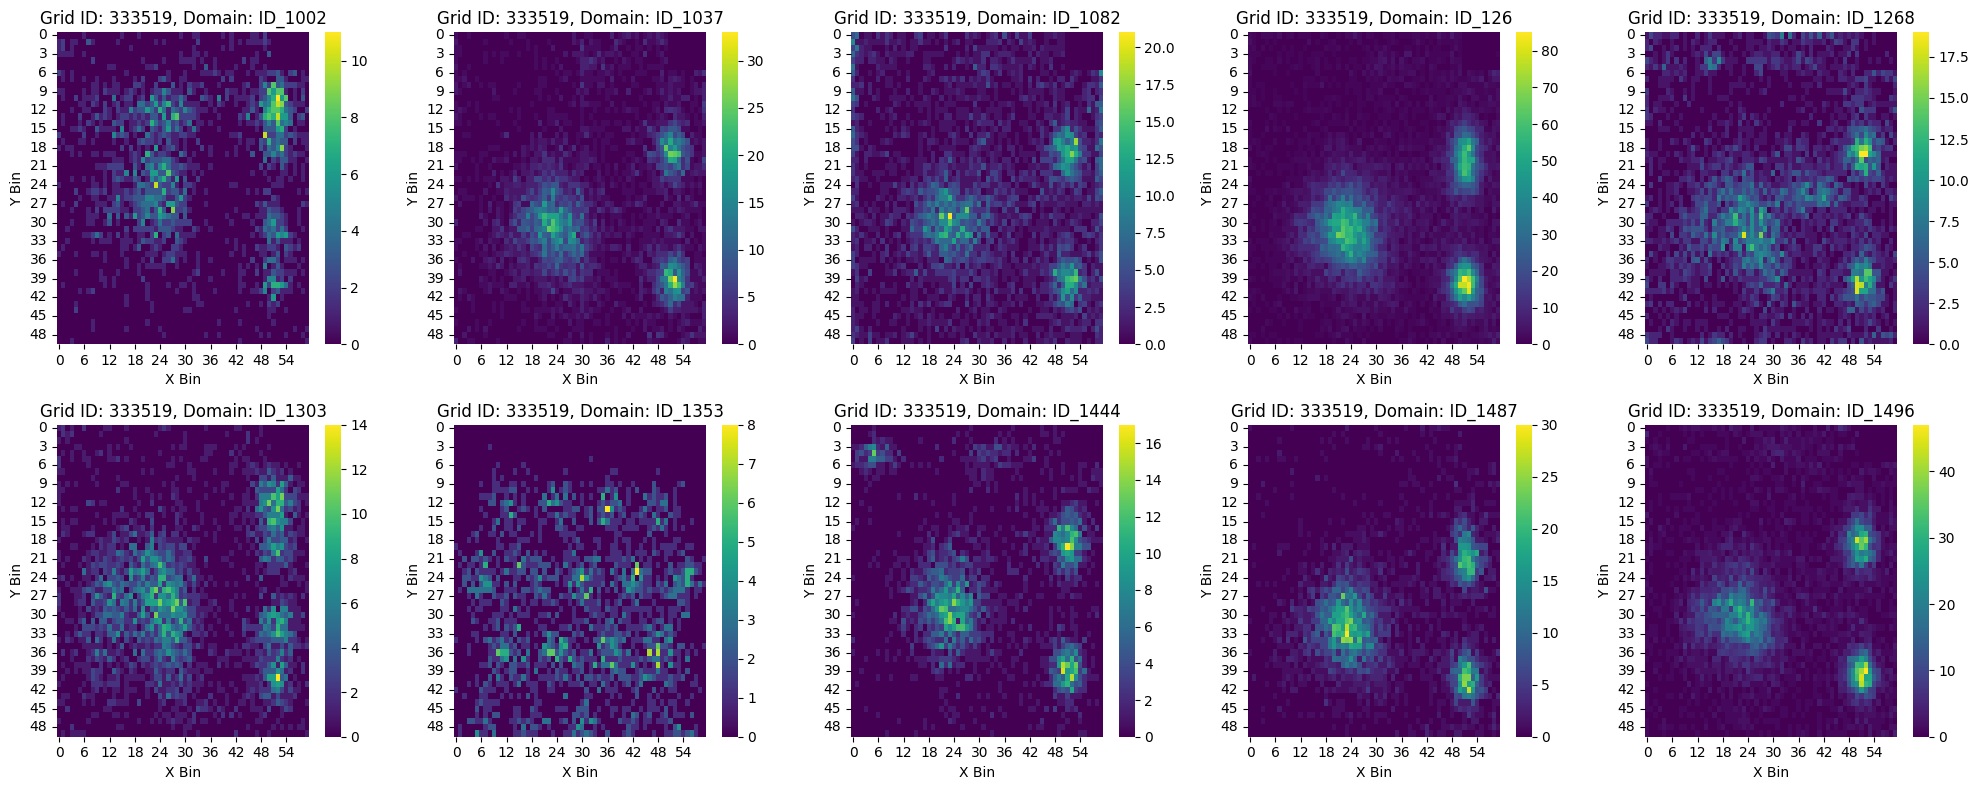

In [120]:
for grid_id in unique_grid_ids:
    anomalies_domains = anomaly_results[grid_id][anomaly_results[grid_id]['anomaly'] == -1]['domain'].head(10)

    plot_heatmaps_from_clicks(grid_id, anomalies_domains, data_heatmap_expanded, NR_OF_X_BINS, NR_OF_Y_BINS)


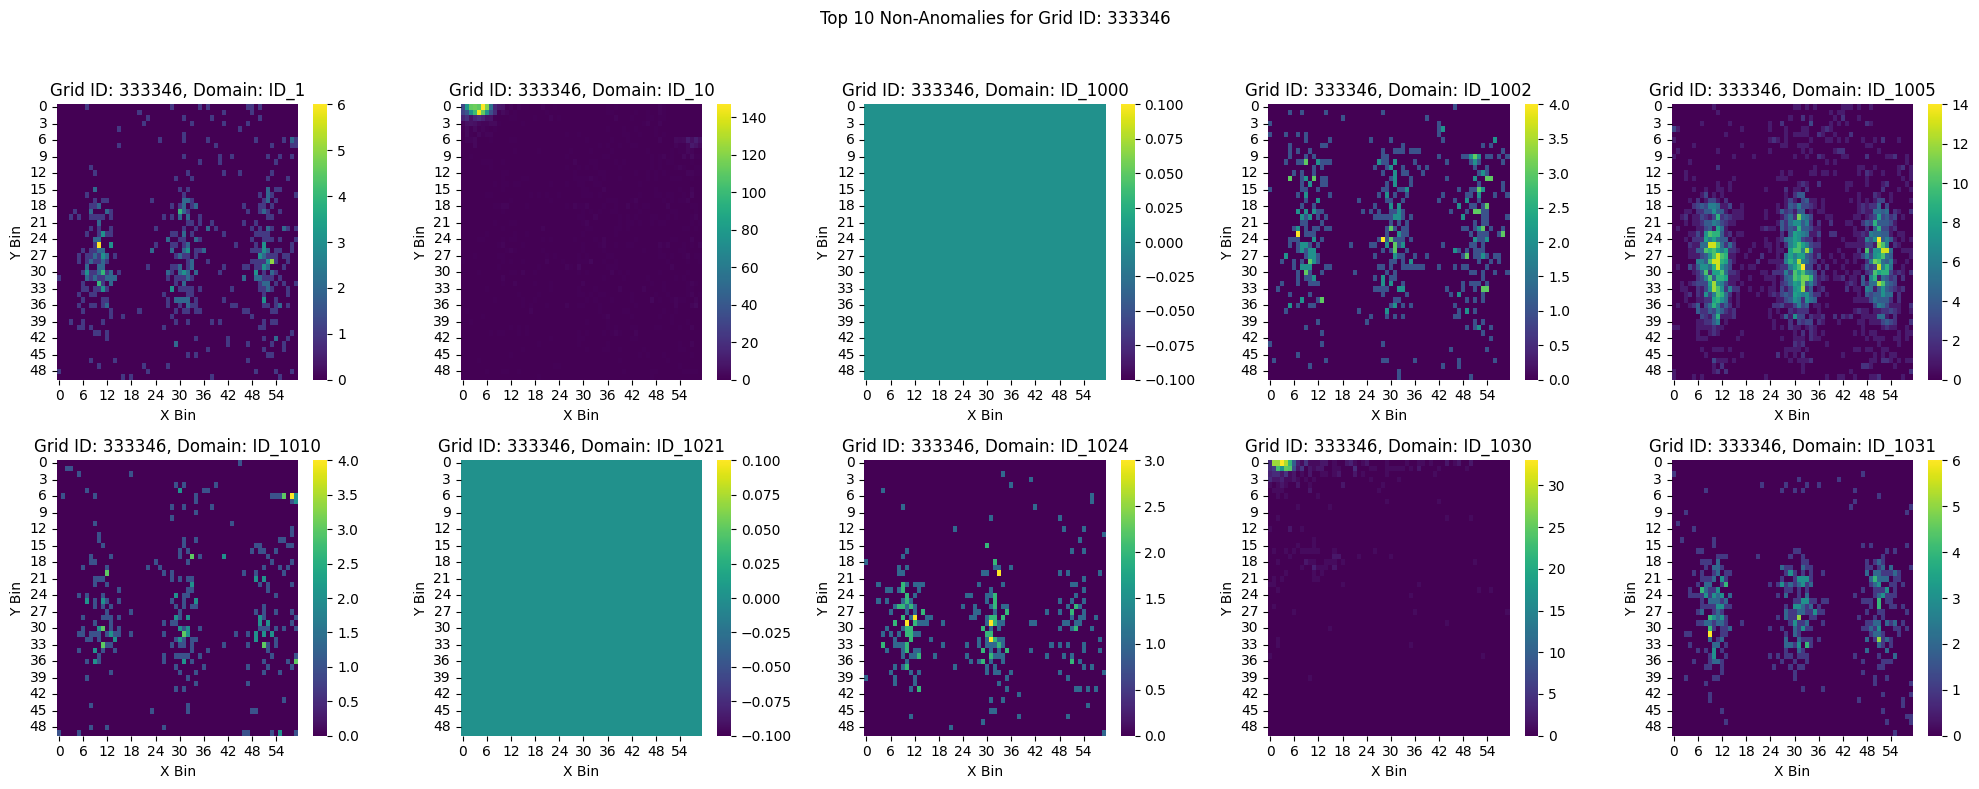

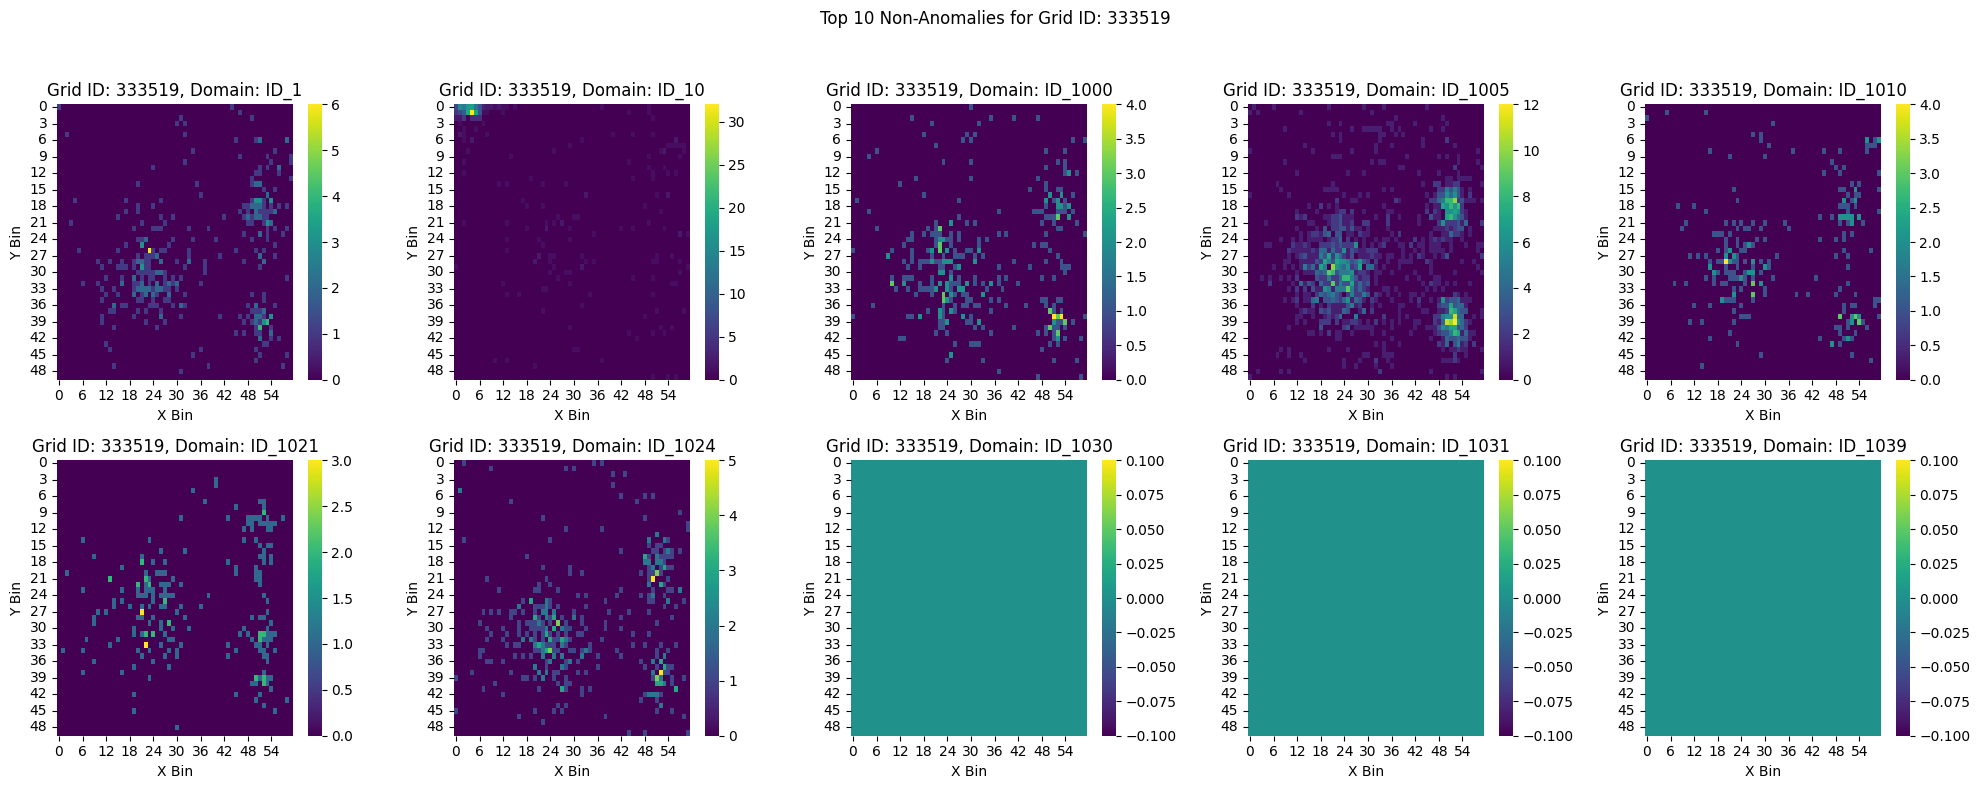

In [122]:
for grid_id in unique_grid_ids:
    non_anomalies_domains = anomaly_results[grid_id][anomaly_results[grid_id]['anomaly'] == 1]['domain'].head(10)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, domain in zip(axes.flatten(), non_anomalies_domains):
        domain_data = data_heatmap_expanded[(data_heatmap_expanded['domain'] == domain) & (data_heatmap_expanded['grid_id'] == grid_id)]

        heatmap_data, _, _ = np.histogram2d(
            x=domain_data['click_x'],
            y=domain_data['click_y'],
            bins=[NR_OF_X_BINS - 1, NR_OF_Y_BINS - 1],
            range=[[0, max_width], [0, max_height]]
        )

        sns.heatmap(heatmap_data.T, ax=ax, cmap="viridis", cbar=True)
        ax.set_title(f'Grid ID: {grid_id}, Domain: {domain}')
        ax.set_xlabel('X Bin')
        ax.set_ylabel('Y Bin')

    plt.suptitle(f'Top 10 Non-Anomalies for Grid ID: {grid_id}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


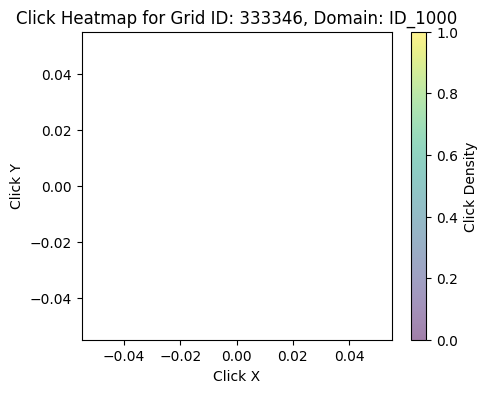

Total Clicks for Grid ID: 333346, Domain: ID_1000: 0
Click Distribution:
       click_x  click_y  clicks
count      0.0      0.0     0.0
mean       NaN      NaN     NaN
std        NaN      NaN     NaN
min        NaN      NaN     NaN
25%        NaN      NaN     NaN
50%        NaN      NaN     NaN
75%        NaN      NaN     NaN
max        NaN      NaN     NaN



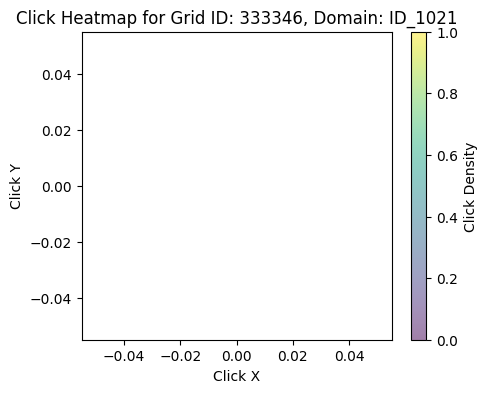

Total Clicks for Grid ID: 333346, Domain: ID_1021: 0
Click Distribution:
       click_x  click_y  clicks
count      0.0      0.0     0.0
mean       NaN      NaN     NaN
std        NaN      NaN     NaN
min        NaN      NaN     NaN
25%        NaN      NaN     NaN
50%        NaN      NaN     NaN
75%        NaN      NaN     NaN
max        NaN      NaN     NaN



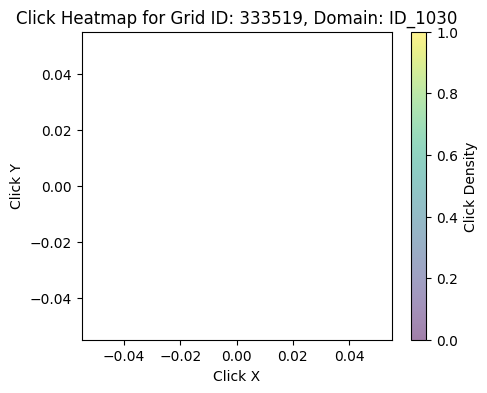

Total Clicks for Grid ID: 333519, Domain: ID_1030: 0
Click Distribution:
       click_x  click_y  clicks
count      0.0      0.0     0.0
mean       NaN      NaN     NaN
std        NaN      NaN     NaN
min        NaN      NaN     NaN
25%        NaN      NaN     NaN
50%        NaN      NaN     NaN
75%        NaN      NaN     NaN
max        NaN      NaN     NaN



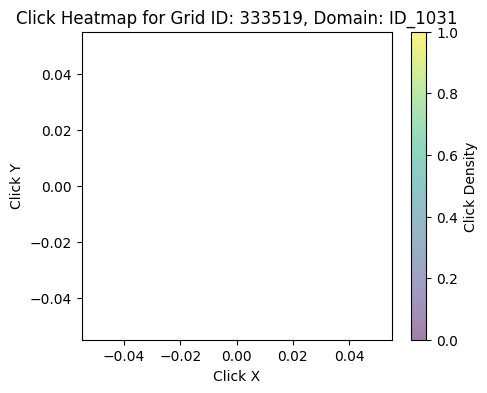

Total Clicks for Grid ID: 333519, Domain: ID_1031: 0
Click Distribution:
       click_x  click_y  clicks
count      0.0      0.0     0.0
mean       NaN      NaN     NaN
std        NaN      NaN     NaN
min        NaN      NaN     NaN
25%        NaN      NaN     NaN
50%        NaN      NaN     NaN
75%        NaN      NaN     NaN
max        NaN      NaN     NaN



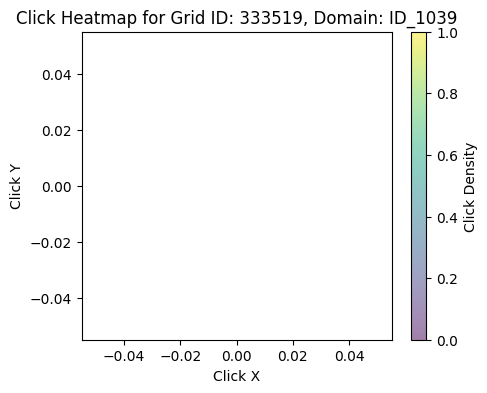

Total Clicks for Grid ID: 333519, Domain: ID_1039: 0
Click Distribution:
       click_x  click_y  clicks
count      0.0      0.0     0.0
mean       NaN      NaN     NaN
std        NaN      NaN     NaN
min        NaN      NaN     NaN
25%        NaN      NaN     NaN
50%        NaN      NaN     NaN
75%        NaN      NaN     NaN
max        NaN      NaN     NaN



In [124]:
#exlplore above blank
combinations = [
    {'grid_id': 333346, 'domain': 'ID_1000'},
    {'grid_id': 333346, 'domain': 'ID_1021'},
    {'grid_id': 333519, 'domain': 'ID_1030'},
    {'grid_id': 333519, 'domain': 'ID_1031'},
    {'grid_id': 333519, 'domain': 'ID_1039'},
]

for combo in combinations:
    filtered_data = data_heatmap[(data_heatmap['grid_id'] == combo['grid_id']) & (data_heatmap['domain'] == combo['domain'])]

    plt.figure(figsize=(5, 4))
    plt.scatter(filtered_data['click_x'], filtered_data['click_y'], alpha=0.5)
    plt.title(f"Click Heatmap for Grid ID: {combo['grid_id']}, Domain: {combo['domain']}")
    plt.xlabel('Click X')
    plt.ylabel('Click Y')
    plt.colorbar(label='Click Density')
    plt.show()

    total_clicks = filtered_data['clicks'].sum()
    print(f"Total Clicks for Grid ID: {combo['grid_id']}, Domain: {combo['domain']}: {total_clicks}")
    print(f"Click Distribution:\n{filtered_data[['click_x', 'click_y', 'clicks']].describe()}\n")


### Check with broken domain from Martin

In [74]:
# check with the broken_domain identify by martin
anomalies_333519 = anomaly_results[333519]

anomaly_domains = anomalies_333519[anomalies_333519['anomaly'] == -1]['domain']

overlap_domains = set(broken_domains).intersection(set(anomaly_domains))

overlap_domains


{'ID_1353', 'ID_1888', 'ID_2076'}

# Martin's Data

## Data Manipulation

In [47]:
# expand so that each row corresponds to 1 click:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [ ]:
data_heatmap

,Unnamed: 0,domain,grid_id,click_x,click_y,display_height,display_width,clicks
0,0,ID_1763,333519,179,4,250,300,1
1,1,ID_1763,333519,262,185,250,300,1
2,2,ID_1763,333519,122,188,250,300,1
3,3,ID_1763,333519,263,197,250,300,1
4,4,ID_1763,333519,242,159,250,300,1
...,...,...,...,...,...,...,...,...
1935421,1935421,ID_1501,333519,163,145,250,300,8
1935422,1935422,ID_1501,333519,41,139,250,300,4
1935423,1935423,ID_1501,333519,213,97,250,300,2
1935424,1935424,ID_1501,333519,271,245,250,300,1


In [48]:
NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'],
                                      bins = width_bins,
                                      labels=False,
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'],
                                      bins=height_bins,
                                      labels=False,
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain',
                                           'click_x_bin',
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [49]:
# add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1),
                                range(0,height_bins_max+1))),
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks,
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'],
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned

,domain,grid_id,click_x_bin,click_y_bin,clicks_sum
0,ID_1763,333519,0,0,0
1,ID_1763,333519,0,1,0
2,ID_1763,333519,0,2,0
3,ID_1763,333519,0,3,0
4,ID_1763,333519,0,4,0
...,...,...,...,...,...
5198995,ID_1382,333346,59,45,0
5198996,ID_1382,333346,59,46,0
5198997,ID_1382,333346,59,47,0
5198998,ID_1382,333346,59,48,0


In [10]:
# for clustering

data_binned[(data_binned.domain == 'ID_1763') &
            (data_binned.grid_id == 333519)]['clicks_sum'].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

In [12]:
# aggregated clicks by grid_id:

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

## Apply Method


### For Martin's Data

In [50]:
# grid IDs
unique_grid_ids = data_binned['grid_id'].unique()

anomaly_results = {}

# apply IF separately
for grid_id in unique_grid_ids:

    data_current_grid = data_binned[data_binned['grid_id'] == grid_id]

    # matrix: each row is a domain and each column is a bin
    data_pivoted = data_current_grid.pivot_table(index='domain', columns=['click_x_bin', 'click_y_bin'], values='clicks_sum', fill_value=0)

    # feature matrix
    X = data_pivoted.values

    # model
    iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
    iso_forest.fit(X)

    # predict
    anomalies = iso_forest.predict(X)  # -1 for anomalies

    anomaly_results[grid_id] = pd.DataFrame({
        'domain': data_pivoted.index,
        'anomaly': anomalies
    })

## Result Exploration

### Martin's Data

#### Percentage

In [51]:
anomaly_percentages = {}

for grid_id, results in anomaly_results.items():
    total_domains = len(results)
    anomalies_count = (results['anomaly'] == -1).sum()
    anomaly_percentage = (anomalies_count / total_domains) * 100
    anomaly_percentages[grid_id] = anomaly_percentage

anomaly_percentages


{333519: 5.6192660550458715, 333346: 5.691056910569105}

In [52]:
total_anomalies = sum((result['anomaly'] == -1).sum() for result in anomaly_results.values())
total_domains_aggregate = sum(len(result) for result in anomaly_results.values())

overall_anomaly_percentage = (total_anomalies / total_domains_aggregate) * 100
overall_anomaly_percentage


5.654933641084824

#### Visualization

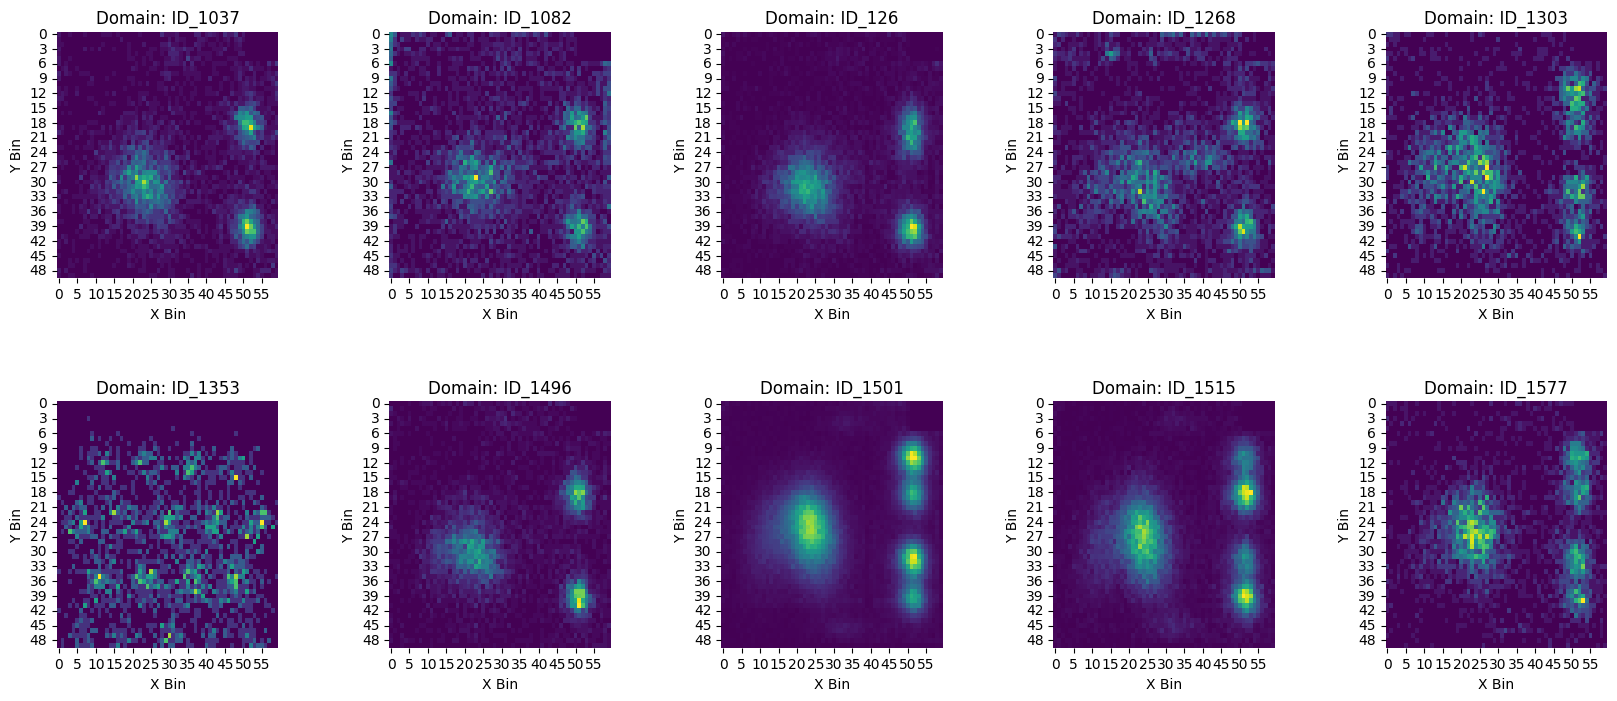

In [59]:
def plot_anomaly_heatmaps(grid_id, results, data_binned, nrows=2, ncols=5):
    anomalies = results[results['anomaly'] == -1]['domain'].head(nrows * ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, domain in zip(axes.flatten(), anomalies):
        domain_data = data_binned[(data_binned['domain'] == domain) & (data_binned['grid_id'] == grid_id)]

        heatmap_data = domain_data.pivot("click_y_bin", "click_x_bin", "clicks_sum")

        sns.heatmap(heatmap_data, ax=ax, cmap="viridis", cbar=False)
        ax.set_title(f'Domain: {domain}')
        ax.set_xlabel('X Bin')
        ax.set_ylabel('Y Bin')

    plt.show()

grid_id = 333519
plot_anomaly_heatmaps(grid_id, anomaly_results[grid_id], data_binned)


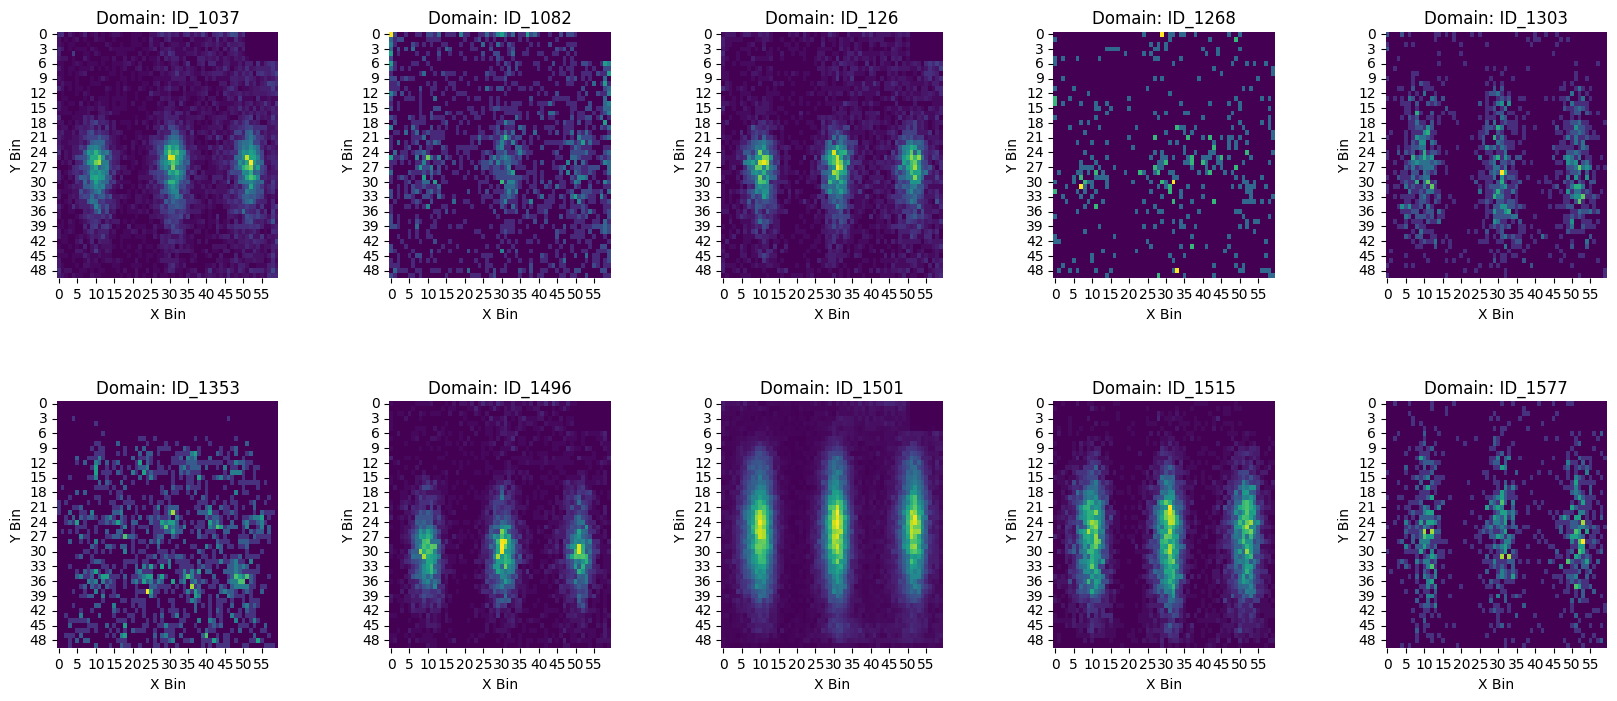

In [62]:
plot_anomaly_heatmaps(list(anomaly_results.keys())[1], anomaly_results[list(anomaly_results.keys())[1]], data_binned)


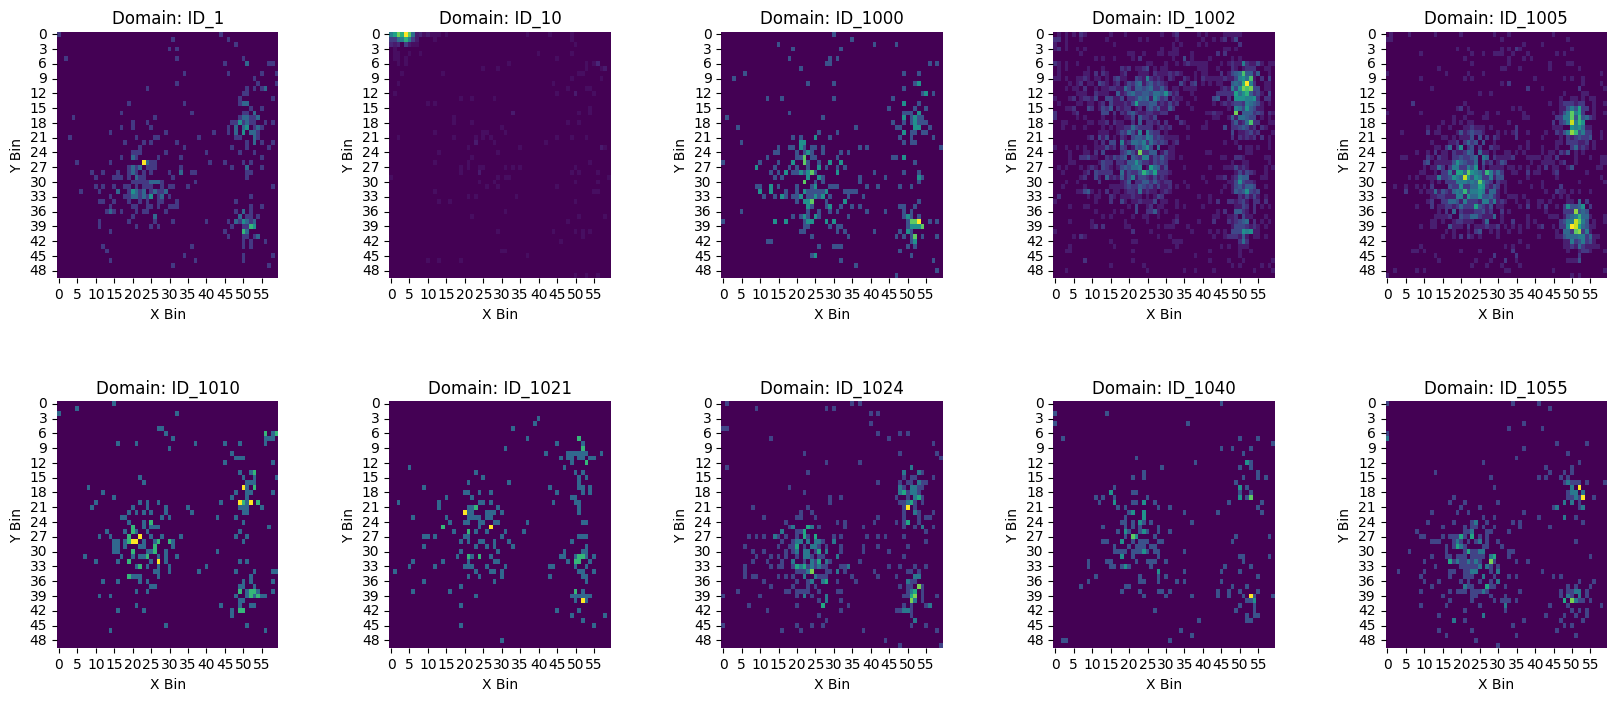

In [64]:
non_anomalies_333519 = anomaly_results[333519][anomaly_results[333519]['anomaly'] == 1]

top_10_non_anomalous_domains = non_anomalies_333519['domain'].head(10)

def plot_non_anomaly_heatmaps(domains, data_binned, grid_id, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, domain in zip(axes.flatten(), domains):
        domain_data = data_binned[(data_binned['domain'] == domain) & (data_binned['grid_id'] == grid_id)]

        heatmap_data = domain_data.pivot("click_y_bin", "click_x_bin", "clicks_sum")

        sns.heatmap(heatmap_data, ax=ax, cmap="viridis", cbar=False)
        ax.set_title(f'Domain: {domain}')
        ax.set_xlabel('X Bin')
        ax.set_ylabel('Y Bin')

    plt.show()

plot_non_anomaly_heatmaps(top_10_non_anomalous_domains, data_binned, 333519)


#### Compare with Clearly Broken Domain ID for 333519

In [61]:
anomalies_333519 = anomaly_results[333519]

anomaly_domains = anomalies_333519[anomalies_333519['anomaly'] == -1]['domain']

overlap_domains = set(broken_domains).intersection(set(anomaly_domains))

overlap_domains


{'ID_1353', 'ID_2076'}